# Malaria Image Classification Project
This project uses a convolutional neural network (CNN) to classify cell images as Parasitized (Infected) or Uninfected based on a publicly available malaria dataset. The goal is to assist in the early detection of malaria infection from microscopic blood smear images using deep learning.

## Import Required Libraries

In [1]:
# Data visualization and analytics
import matplotlib.pyplot as plt # Plot graphs and images
import numpy as np              # Handle arrays and numerical data
import seaborn as sns           # Generate heatmaps and styled plots

# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report

# File and image processing
import os   # Work with file paths
import shutil  # File operations
import cv2  # Image loading and resizing

# TensorFlow / Keras modules for building CNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator                # Image augmentation
from tensorflow.keras.models import Sequential                                     # Model type (sequential layers)
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # Layers for CNN
from tensorflow.keras.callbacks import EarlyStopping                               # Stop training early if overfitting

## Dataset Setup & Cleaning
In this section, we will download the Malaria Cell Images dataset directly from Kaggle into our Colab environment.
The dataset contains two categories of cell images:
*   Parasitized (Infected with Malaria)
*   Uninfected



In [2]:
RAW_DATA_DIR = "data/raw"
BASE_DIR = os.path.join(RAW_DATA_DIR, "cell_images") # Where Kaggle dataset is unzipped
CLEAN_DIR = os.path.join(RAW_DATA_DIR, "clean_cell_images") # Clean folder for training

# Make sure raw folder exists
os.makedirs(RAW_DATA_DIR, exist_ok=True)

# Set Kaggle config directory to current folder
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

# Check for kaggle.json (you need to upload it in Colab first)
if not os.path.exists('kaggle.json'):
    raise FileNotFoundError("Kaggle API token file 'kaggle.json' not found. Please upload it to the current directory.")

# Download & unzip dataset **only if it doesn't exist**
if not os.path.exists(BASE_DIR):
    !kaggle datasets download -d 'iarunava/cell-images-for-detecting-malaria' -p {RAW_DATA_DIR} --unzip
else:
    print("Dataset already downloaded and unzipped.")

# Detect whether there is a nested cell_images folder
if os.path.exists(os.path.join(BASE_DIR, "cell_images")):
  # Nested case: cell_images/cell_images/Parasitized
  DATA_SOURCE_DIR = os.path.join(BASE_DIR, "cell_images")
else:
  # Normal case: cell_images/Parasitized
  DATA_SOURCE_DIR = BASE_DIR

print("Using data source dictionary:", DATA_SOURCE_DIR)

# Remove old clean folder if it exists
if os.path.exists(CLEAN_DIR):
  shutil.rmtree(CLEAN_DIR)

# Copy clean structure
shutil.copytree(
    os.path.join(DATA_SOURCE_DIR, "Parasitized"),
    os.path.join(CLEAN_DIR, "Parasitized")
)

shutil.copytree(
    os.path.join(DATA_SOURCE_DIR, "Uninfected"),
    os.path.join(CLEAN_DIR, "Uninfected")
)

print("Clean dataset ready at:", CLEAN_DIR)

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 99% 670M/675M [00:00<00:00, 1.73GB/s]
100% 675M/675M [00:00<00:00, 1.73GB/s]
Using data source dictionary: data/raw/cell_images/cell_images
Clean dataset ready at: data/raw/clean_cell_images


## Data Exploration
In this section, we will:
1.   List all images in the Parasitized and Uninfected folders
2.   Display example images to understand the dataset



Number of Parasitized images: 13780
Number of Uninfected images: 13780


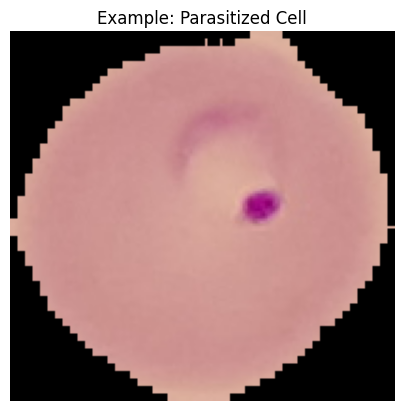

In [3]:
# List all images in each category
parasitized = os.listdir('data/raw/cell_images/Parasitized')
uninfected = os.listdir('data/raw/cell_images/Uninfected')

print(f"Number of Parasitized images: {len(parasitized)}")
print(f"Number of Uninfected images: {len(uninfected)}")

# Display an example image from the Parasitized class
img_path = 'data/raw/cell_images/Parasitized/' + parasitized[0]
img = cv2.imread(img_path)

# Convert from BGR (OpenCV default) to RGB for correct plotting
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# SDhow the image
plt.imshow(img_rgb)
plt.title("Example: Parasitized Cell")
plt.axis('off')
plt.show()

## Data Preprocessing and Augmentation
We use Keras' ImageDataGenerator to:
1.   Normalize pixel values (rescale from 0-255 to 0-1)
2.   Perform real-time data augmentation to improve generalization
3.   Split data into training (80%) and validation (20%)








In [4]:
DATA_SET_PATH = 'data/raw/clean_cell_images'
# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=20,        # Randomly rotate images by up to 20 degrees
    width_shift_range=0.1,    # Shift images horizontally by up to 10%
    height_shift_range=0.1,   # Shift images vertically by up to 10%
    shear_range=0.2,          # Shear transformations
    zoom_range=0.1,           # Zoom in/out randomly
    horizontal_flip=True,     # Flip images horizontally
    fill_mode='nearest',      # Fill in new pixels after transformations
    validation_split=0.2      # Reserve 20% of data for validation
)

# Validation Data Generator
val_datagen = ImageDataGenerator(
    rescale=1./255,           # Only normalize pixel values for validation
    validation_split=0.2
)

# Create Training Dataset Generator
train = train_datagen.flow_from_directory(
    CLEAN_DIR, # Path to dataset
    target_size=(128,128),                    # Resize all images to 128x128 pixels
    batch_size=32,                            # Number of images per batch
    class_mode='binary',                      # Binary classification: Parasitized vs Uninfected
    subset='training',                        # Uses 80% of images for training
    shuffle=True                              # Shuffle images each epoch
)

# Create Validation Dataset Generator
val = val_datagen.flow_from_directory(
    CLEAN_DIR,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='validation',                      # Uses 20% of images for validation
    shuffle=False                             # No need to shuffle for validation
    )

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


## Baseline Model: Custom CNN
- Build
- Train
- Evaluate
- Save metrics

### Build and Train the CNN Model
This section creates a simple Convolutional Neural Network (CNN) to classify malaria-infected vs uninfected cells. EarlyStopping is used to prevent overfitting.

In [5]:
# Early Stopping Callback
early_stop = EarlyStopping(
    monitor='val_loss',         # Monitor the validation loss
    patience=3,                 # Stop training if val_loss does not improve for 3 epochs
    restore_best_weights=True   # Restore model weights from the epoch with the best val_loss
)

# Build the CNN Model
model = Sequential([
    # 1st Convolutional Layer
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2), # Downsample feature maps by 2x2

    # 2nd Convolutional Layer
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Flatten to 1D vector for Dense layers
    Flatten(),

    # Fully connected layer
    Dense(128, activation='relu'),
    Dropout(0.5),     # Dropout to prevent overfitting

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the Model
model.compile(
    optimizer='adam',           # Adaptive optimizer
    loss='binary_crossentropy', # Binary classification loss
    metrics=['accuracy']        # Track accuracy during training
)

# Train the Model
history = model.fit(
    train,                  # Training data generator
    validation_data=val,    # Validation data generator
    epochs=30,              # Max number of epochs
    callbacks=[early_stop]  # Stop early if validation loss stops improving
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 106s 146ms/step - accuracy: 0.6834 - loss: 0.6210 - val_accuracy: 0.8871 - val_loss: 0.3266
Epoch 2/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 99s 144ms/step - accuracy: 0.8948 - loss: 0.3322 - val_accuracy: 0.9236 - val_loss: 0.2468
Epoch 3/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 99s 143ms/step - accuracy: 0.9282 - loss: 0.2401 - val_accuracy: 0.9338 - val_loss: 0.1964
Epoch 4/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 99s 144ms/step - accuracy: 0.9370 - loss: 0.2039 - val_accuracy: 0.9350 - val_loss: 0.1987
Epoch 5/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 99s 144ms/step - accuracy: 0.9368 - loss: 0.2078 - val_accuracy: 0.9368 - val_loss: 0.1919
Epoch 6/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 99s 144ms/step - accuracy: 0.9422 - loss: 0.1895 - val_accuracy: 0.9381 - val_loss: 0.1815
Epoch 7/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 99s 144ms/step - accuracy: 0.9434 - loss: 0.1783 - val_accuracy: 0.9381 - val_loss: 0.1977
Epoch 8/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 99s 143ms/step - accuracy: 0.9464 - loss: 

### Model Evaluation and Visualization
Evaluate the trained CNN on the validation set.
Generate confusion matrix, classification report, and accuracy/loss plots.

173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9214 - loss: 0.2110
Validation Accuracy: 0.9381
Validation Loss: 0.1815


173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step


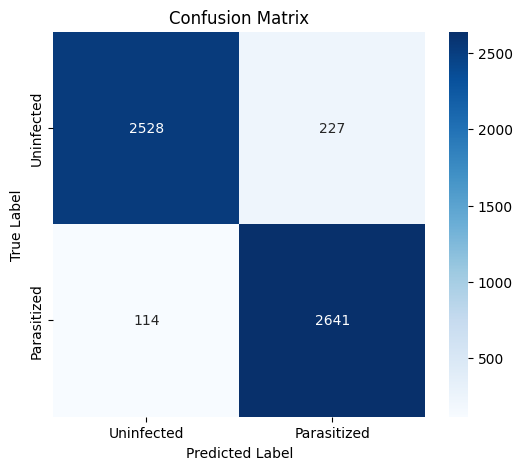

Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.96      0.92      0.94      2755
 Parasitized       0.92      0.96      0.94      2755

    accuracy                           0.94      5510
   macro avg       0.94      0.94      0.94      5510
weighted avg       0.94      0.94      0.94      5510



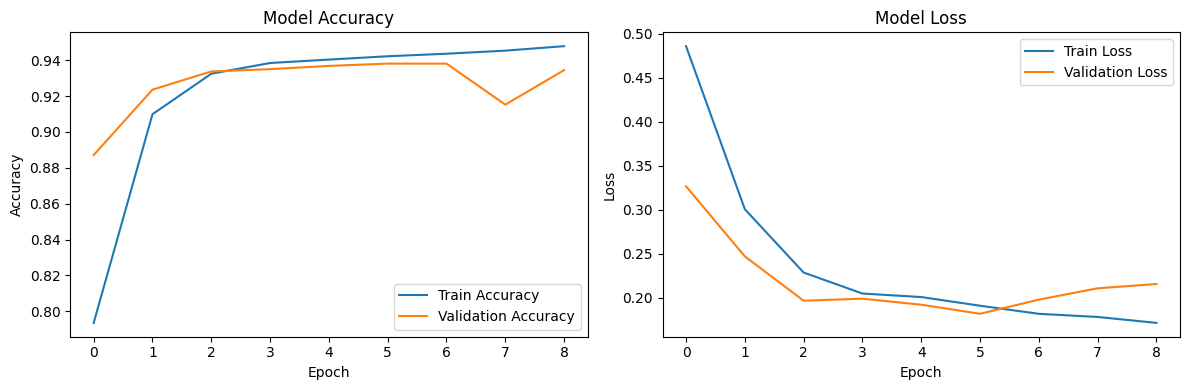

In [6]:
# Evaluate Model on Validation Data
val_loss, val_acc = model.evaluate(val)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print("\n")

# Predict on Validation Data
# model.predict returns probabilities (0 to 1)
y_pred_probs = model.predict(val, steps=len(val))
y_pred = (y_pred_probs > 0.5).astype("int32").ravel() # Convert probabilities to 0 or 1

# True labels from the validation generator
y_true = val.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot it
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Uninfected','Parasitized'],
    yticklabels=['Uninfected','Parasitized']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Uninfected','Parasitized']))

# Plot Training History
plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Transfer Learning Model 1: MobileNetV2
- Build
- Train
- Evaluate
- Save metrics

In [8]:
# Import MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [10]:
# Build the MobileNetV2 Model
# Load pretrained MobileNetV2 without the top classifier
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False, # Remove ImageNet classifier
    weights="imagenet"
)

# Freeze the base model so we don't destroy pretrained features
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=output)

# Compile
mobilenet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# Train MobileNetV2
early_stop_mobilenet = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_mobilenet = mobilenet_model.fit(
    train,
    validation_data=val,
    epochs=15,
    callbacks=[early_stop_mobilenet]
)

Epoch 1/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 142s 172ms/step - accuracy: 0.8505 - loss: 0.3431 - val_accuracy: 0.8829 - val_loss: 0.2836
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 99s 144ms/step - accuracy: 0.9044 - loss: 0.2490 - val_accuracy: 0.8953 - val_loss: 0.3064
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 100s 145ms/step - accuracy: 0.9149 - loss: 0.2260 - val_accuracy: 0.9114 - val_loss: 0.2522
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 99s 144ms/step - accuracy: 0.9177 - loss: 0.2218 - val_accuracy: 0.9056 - val_loss: 0.2522
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 99s 144ms/step - accuracy: 0.9182 - loss: 0.2148 - val_accuracy: 0.8998 - val_loss: 0.2955
Epoch 6/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 100s 145ms/step - accuracy: 0.9153 - loss: 0.2211 - val_accuracy: 0.8978 - val_loss: 0.2810
Epoch 7/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 99s 144ms/step - accuracy: 0.9149 - loss: 0.2209 - val_accuracy: 0.9132 - val_loss: 0.2472
Epoch 8/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 100s 145ms/step - accuracy: 0.9255 - los

173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8793 - loss: 0.3411
MobileNetV2 Validation Accuracy: 0.9132
MobileNetV2 Validation Loss: 0.2472
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step


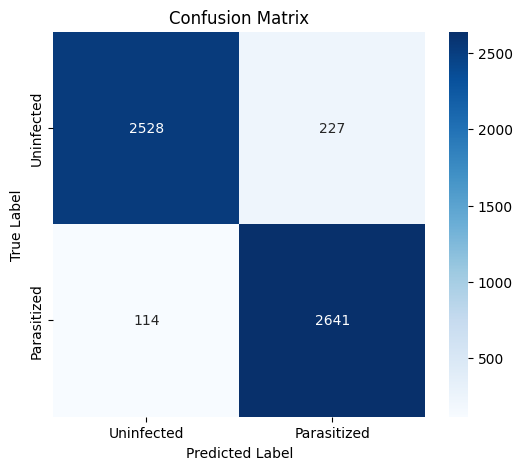

In [14]:
# Evaluate MobileNetV2
val_loss_mn, val_acc_mn = mobilenet_model.evaluate(val)
print(f"MobileNetV2 Validation Accuracy: {val_acc_mn:.4f}")
print(f"MobileNetV2 Validation Loss: {val_loss_mn:.4f}")

# Predict on Validation Data
# model.predict returns probabilities (0 to 1)
y_pred_probs = model.predict(val, steps=len(val))
y_pred = (y_pred_probs > 0.5).astype("int32").ravel() # Convert probabilities to 0 or 1

# True labels from the validation generator
y_true = val.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot it
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Uninfected','Parasitized'],
    yticklabels=['Uninfected','Parasitized']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Transfer Learning Model 2: ResNet50

## Model Comparison
- Table of accuracies
- Loss/accuracy curves

In [17]:
import pandas as pd

results = [
    {"Model": "Custom CNN", "Validation Accuracy": val_acc},
    {"Model": "MobileNetV2 (Transfer Learning)", "Validation Accuracy": val_acc_mn},
]

df = pd.DataFrame(results)
df

,Model,Validation Accuracy
0,Custom CNN,0.938112
1,MobileNetV2 (Transfer Learning),0.913249


## Save Best Model(s)

In [16]:
from google.colab import files

# Save the baseline CNN model
model.save('malaria_model.keras')
print('Successfully saved model!')

# Save the MobileNetV2 Model
mobilenet_model.save("malaria_mobilenetv2.keras")
print("Saved MobileNetV2 model.")

# Download the saved model to your local machine
files.download('malaria_model.keras')
files.download('malaria_mobilenetv2.keras')

Successfully saved model!
Saved MobileNetV2 model.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>